In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten
from keras.applications import Xception


2024-04-30 04:17:52.830428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 04:17:52.830537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 04:17:52.964184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Flatten,MaxPooling2D,Conv2D,Activation
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import os
import glob

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [4]:
encoder=OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5]])

OneHotEncoder()

# Load the dataset

In [5]:
image_data='/kaggle/input/emotion-recognition-dataset/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


In [6]:
files_l = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files_l)
labels_l = [os.path.dirname(i).split("/")[-1] for i in files_l]
data_l = zip(files_l, labels_l)

In [7]:
dataframe_l = pd.DataFrame(data_l, columns = ["Image", "Label"])

In [8]:
print(dataframe_l )

                                                   Image    Label
0      /kaggle/input/emotion-recognition-dataset/data...    Happy
1      /kaggle/input/emotion-recognition-dataset/data...      Sad
2      /kaggle/input/emotion-recognition-dataset/data...    Happy
3      /kaggle/input/emotion-recognition-dataset/data...  Neutral
4      /kaggle/input/emotion-recognition-dataset/data...    Happy
...                                                  ...      ...
15448  /kaggle/input/emotion-recognition-dataset/data...  Neutral
15449  /kaggle/input/emotion-recognition-dataset/data...    Angry
15450  /kaggle/input/emotion-recognition-dataset/data...  Neutral
15451  /kaggle/input/emotion-recognition-dataset/data...  Neutral
15452  /kaggle/input/emotion-recognition-dataset/data...  Neutral

[15453 rows x 2 columns]


### To know the shape of the image

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
# Load the image
image_path = "/kaggle/input/emotion-recognition-dataset/dataset/Ahegao/cropped_emotions.16023~ahegao.png"

image = Image.open(image_path)

# Print the size of the image
print("Image size:", image.size)

Image size: (264, 382)


## Count the no.of images in each cateogary

In [11]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/input/emotion-recognition-dataset/dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Define an empty dictionary to store the counts of images for each class
class_counts = {}
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Surprise: 1234 images
Angry: 1313 images
Neutral: 4027 images
Sad: 3934 images
Happy: 3740 images
Ahegao: 1205 images
Total images: 15453


# Data Visualisation

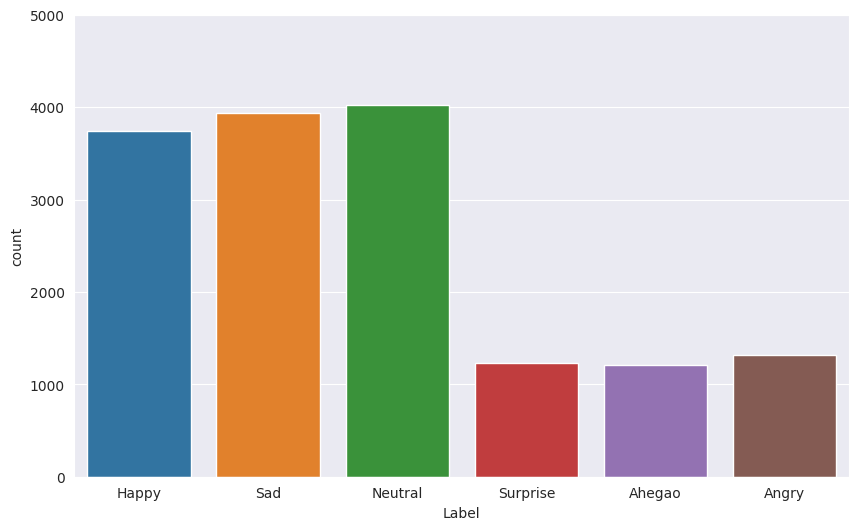

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=dataframe_l ["Label"])

# Get the counts for each class
class_counts = dataframe_l ["Label"].value_counts()
# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Limit y-axis range up to 6000
plt.ylim(0, 5000)

# Show plot
plt.show()

# Data Preprocessing

## Defining image paramater

In [13]:
image_data = '/kaggle/input/emotion-recognition-dataset/dataset'
train_data_dir = image_data
train_data_dir = image_data
batch_size = 64
target_size = (224, 224)
validation_split= 0.2

## Defining augmentation parameters

In [14]:
augmentation_params = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Count images in each class

In [15]:
def count_images(class_name):
    class_path = os.path.join(train_data_dir, class_name)
    return len(os.listdir(class_path))

### Determining the classes to augment


In [16]:
classes_to_augment = ['Neutral','Sad','Happy','Ahegao', 'Angry', 'Surprise']
target_count = 4500

### Created an output directory


In [17]:
output_dir = '/kaggle/working/augmented_images'

## Performing data augmentation

In [18]:
for class_name in classes_to_augment:
    current_count = count_images(class_name)
    if current_count < target_count:
        augment_count = target_count - current_count
        augment_dir = os.path.join(output_dir, class_name)  # Save augmented images to a new directory
        os.makedirs(augment_dir, exist_ok=True)  # Create the directory if it doesn't exist
        augment_datagen = ImageDataGenerator(**augmentation_params)
        augment_generator = augment_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            classes=[class_name],
            save_to_dir=augment_dir,
            save_prefix='augmented',
            save_format='png'
        )
        # Generate augmented images until the target count is reached
        i = 0
        for batch in augment_generator:
            i += 1
            if i >= augment_count / batch_size:
                break

Found 4027 images belonging to 1 classes.
Found 3934 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 1205 images belonging to 1 classes.
Found 1313 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


## Count of augmented images

In [19]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/working/augmented_images'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")


Neutral: 512 images
Sad: 576 images
Happy: 768 images
Angry: 3138 images
Surprise: 3236 images
Ahegao: 3306 images
Total images: 11536


## Combining original images and augmented images

In [20]:
import os
import shutil

# Define paths
original_data_path ='/kaggle/input/emotion-recognition-dataset/dataset'
augmented_data_path = '/kaggle/working/augmented_images'
new_data_path = '/kaggle/working/merged_dataset'

# Get the list of classes
classes = os.listdir(original_data_path)
classes

['Surprise', 'Angry', 'Neutral', 'Sad', 'Happy', 'Ahegao']

In [21]:
# Create directories for each class in the new data path
for class_name in classes:
    os.makedirs(os.path.join(new_data_path, class_name), exist_ok=True)

# Copy images from the original data path to the new data path
for class_name in classes:
    original_class_path = os.path.join(original_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(original_class_path):
        shutil.copy(os.path.join(original_class_path, filename), os.path.join(new_class_path, filename))

# Copy images from the augmented data path to the new data path
for class_name in classes:
    augmented_class_path = os.path.join(augmented_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(augmented_class_path):
        shutil.copy(os.path.join(augmented_class_path, filename), os.path.join(new_class_path, filename))

print("Data merge complete.")


Data merge complete.


## Count of combined images

In [22]:
# Define the directory containing the dataset
merged_dataset = '/kaggle/working/merged_dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(merged_dataset) if os.path.isdir(os.path.join(merged_dataset, d))]

# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(merged_dataset, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Neutral: 4539 images
Sad: 4510 images
Happy: 4508 images
Angry: 4451 images
Surprise: 4470 images
Ahegao: 4511 images
Total images: 26989


In [23]:
image_path2 = "/kaggle/working/merged_dataset/Ahegao/cropped_emotions.16023~ahegao.png"
image2 = Image.open(image_path2)
# Print the size of the image
print("Image size:", image2.size)

Image size: (264, 382)


In [24]:
merged_dataset = '/kaggle/working/merged_dataset'

## Organising the data into separate paths for each cateogary

In [25]:
data=[]
result=[]

In [26]:
paths=[]
# Process images in 'Ahegao' folder
for r, d, f in os.walk('/kaggle/working/merged_dataset/Ahegao'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))

for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [27]:
paths=[]
# Process images in 'Angry' folder
for r, d, f in os.walk('/kaggle/working/merged_dataset/Angry'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [28]:
paths=[]
# Process images in 'Happy' folder           
for r,d,f in os.walk('/kaggle/working/merged_dataset/Happy'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())            

In [29]:
paths=[]
# Process images in 'Neutral' folder            
for r,d,f in os.walk('/kaggle/working/merged_dataset/Neutral'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())            

In [30]:
paths=[]
# Process images in 'Sad' folder
for r,d,f in os.walk('/kaggle/working/merged_dataset/Sad'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[4]]).toarray())            

In [31]:
paths=[]
# Process images in 'Surprise' folder         
for r,d,f in os.walk('/kaggle/working/merged_dataset/Surprise'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[5]]).toarray())            

In [32]:
data=np.array(data)
data.shape

(26984, 128, 128, 3)

In [33]:
result=np.array(result)

In [34]:
len(result)

26984

In [35]:
result=result.reshape(26984,6)

# Train-test split

In [36]:
x_train,x_test,y_train,y_test=train_test_split(data,result,test_size=0.2,shuffle=True,random_state=0)

In [37]:
print(len(x_train))
print(len(x_test))

21587
5397


In [38]:
print(len(y_train))
print(len(y_test))

21587
5397


# Implementing Xception Net

In [39]:
base_model_Xception = tf.keras.applications.Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
Xception_model = Sequential()
Xception_model.add(base_model_Xception)

Xception_model.add(GlobalAveragePooling2D())
Xception_model.add(Dense(1024, activation='relu'))
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(BatchNormalization())
Xception_model.add(Dense(256, activation='relu'))
Xception_model.add(BatchNormalization())
Xception_model.add(Flatten())
Xception_model.add(Dense(6, activation='softmax'))


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
Xception_model.build((None, 128,128,3))
Xception_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,620,398 (90.10 MB)

 Trainable params: 23,564,334 (89.89 MB)

 Non-trainable params: 56,064 (219.00 KB)

## Compiling the model

In [41]:
Xception_model.compile(optimizer='Adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])


## Training model with 25 epoch

In [43]:
Xception_history = Xception_model.fit(x_train,
                    y_train, 
                    epochs=25, 
                    batch_size=64, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Epoch 1/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6171 - loss: 1.0117

W0000 00:00:1714452171.389814     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 143s 263ms/step - accuracy: 0.6174 - loss: 1.0109 - val_accuracy: 0.7936 - val_loss: 0.6031
Epoch 2/25


W0000 00:00:1714452180.568056     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.8624 - loss: 0.3808 - val_accuracy: 0.8279 - val_loss: 0.4958
Epoch 3/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 181ms/step - accuracy: 0.9096 - loss: 0.2477 - val_accuracy: 0.8451 - val_loss: 0.4279
Epoch 4/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9299 - loss: 0.1990 - val_accuracy: 0.8373 - val_loss: 0.4956
Epoch 5/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9512 - loss: 0.1433 - val_accuracy: 0.8243 - val_loss: 0.5556
Epoch 6/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9521 - loss: 0.1442 - val_accuracy: 0.8134 - val_loss: 0.7281
Epoch 7/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9563 - loss: 0.1229 - val_accuracy: 0.7864 - val_loss: 0.8380
Epoch 8/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9711 - loss: 0.0875 - val_accuracy: 0.8390 - val_loss: 0.5438
Epoch 9/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9745 - loss: 0.0791 - val

## Evaluation Metrics

In [44]:
print("Training Accuracy:", Xception_history.history['accuracy'][-1])
print("Validation Accuracy:", Xception_history.history['val_accuracy'][-1])

Training Accuracy: 0.9869365692138672
Validation Accuracy: 0.8506577610969543


In [45]:
print("Training Loss:",Xception_history.history['loss'][-1])
print("Test Loss:",Xception_history.history['val_loss'][-1])

Training Loss: 0.0434388667345047
Test Loss: 0.661137580871582


In [46]:
final_epoch_predictions_Xception = Xception_model.predict(x_test)
final_epoch_predicted_labels_Xception = np.argmax(final_epoch_predictions_Xception, axis=1)
true_labels_Xception = np.argmax(y_test, axis=1)

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report,f1_score
from tensorflow.keras.models import clone_model

In [48]:
precision_Xception = precision_score(true_labels_Xception, final_epoch_predicted_labels_Xception, average='weighted')
recall_Xception= recall_score(true_labels_Xception, final_epoch_predicted_labels_Xception, average='weighted')
f1_Xception = f1_score(true_labels_Xception, final_epoch_predicted_labels_Xception, average='weighted')

print("Precision:", precision_Xception)
print("Recall:", recall_Xception)
print("F1-score:", f1_Xception)


Precision: 0.8620193779871376
Recall: 0.8506577728367611
F1-score: 0.850849841333244


In [49]:
conf_matrix_Xception= confusion_matrix(true_labels_Xception, final_epoch_predicted_labels_Xception)
print("Confusion Matrix:\n", conf_matrix_Xception)

Confusion Matrix:
 [[827   0  28   3   1   6]
 [  0 779  24  51  27  10]
 [  0   0 872  12   4   3]
 [  1  21  41 786  81  12]
 [  0  22  39 224 579   9]
 [  7  16  95  60   9 748]]


## Classification Report

In [50]:
class_report_Xception = classification_report(true_labels_Xception, final_epoch_predicted_labels_Xception)
print("Classification Report:\n", class_report_Xception)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       865
           1       0.93      0.87      0.90       891
           2       0.79      0.98      0.88       891
           3       0.69      0.83      0.76       942
           4       0.83      0.66      0.74       873
           5       0.95      0.80      0.87       935

    accuracy                           0.85      5397
   macro avg       0.86      0.85      0.85      5397
weighted avg       0.86      0.85      0.85      5397



## Plot graphs

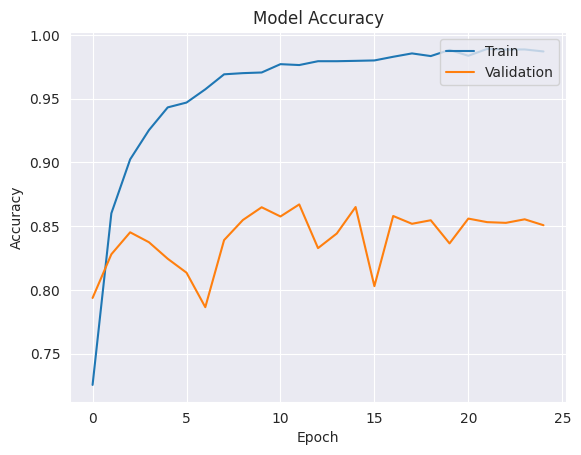

In [51]:
plt.plot(Xception_history.history['accuracy'])
plt.plot(Xception_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

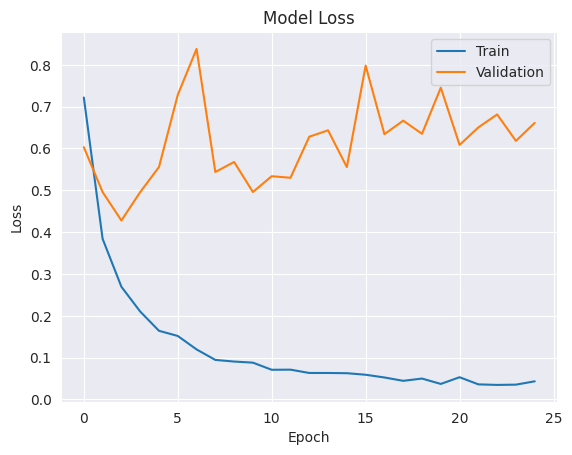

In [52]:
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()